<a href="https://colab.research.google.com/github/davidgonmar/miscellanea/blob/main/deep-variational-information-bottleneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of the ideas on https://arxiv.org/abs/1612.00410.

In [7]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

Z_DIM = 64
BETA = 1e-1
EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-3
SEED = 42
NUM_WORKERS = 2
MC_EVAL = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_ROOT = "./data"


def seed_all(s: int) -> None:
    random.seed(s)
    torch.manual_seed(s)

class MLPEncoder(nn.Module):
    def __init__(self, in_dim: int, z_dim: int, hidden=(512, 256)) -> None:
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        self.net = nn.Sequential(*layers)
        self.mu = nn.Linear(last, z_dim)
        self.logvar = nn.Linear(last, z_dim)

    def forward(self, x: torch.Tensor):
        h = self.net(x)
        return self.mu(h), self.logvar(h)


class Classifier(nn.Module):
    def __init__(self, z_dim: int, num_classes: int) -> None:
        super().__init__()
        self.head = nn.Linear(z_dim, num_classes)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.head(z)


class VIB(nn.Module):
    def __init__(self, enc: nn.Module, clf: nn.Module) -> None:
        super().__init__()
        self.encoder = enc
        self.classifier = clf

    @staticmethod
    def reparam(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    @staticmethod
    def kl(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        return 0.5 * (mu.pow(2) + logvar.exp() - 1.0 - logvar).sum(dim=1)

    def forward(self, x: torch.Tensor):
        mu, logvar = self.encoder(x)
        z = self.reparam(mu, logvar)
        logits = self.classifier(z)
        return logits, mu, logvar


def get_mnist():
    t = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda t: t.view(-1))])
    tr = datasets.MNIST(DATA_ROOT, train=True, download=True, transform=t)
    te = datasets.MNIST(DATA_ROOT, train=False, download=True, transform=t)
    in_dim = 28 * 28
    num_classes = 10
    tr_loader = DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    te_loader = DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    return tr_loader, te_loader, in_dim, num_classes


@torch.no_grad()
def evaluate(model: VIB, loader: DataLoader):
    model.eval()
    ce_list = []
    kl_list = []
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits_acc = 0
        kl_acc = 0
        for _ in range(max(1, MC_EVAL)):
            logits, mu, logvar = model(x)
            logits_acc = logits_acc + logits
            kl_acc = kl_acc + VIB.kl(mu, logvar)
        logits = logits_acc / max(1, MC_EVAL)
        kl = kl_acc / max(1, MC_EVAL)
        ce = F.cross_entropy(logits, y, reduction="none")
        ce_list.append(ce.detach())
        kl_list.append(kl.detach())
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    ce = torch.cat(ce_list).mean().item()
    kl = torch.cat(kl_list).mean().item()
    acc = correct / max(1, total)
    return ce, kl, acc


seed_all(SEED)
tr_loader, te_loader, IN_DIM, NUM_CLASSES = get_mnist()
enc = MLPEncoder(IN_DIM, Z_DIM)
clf = Classifier(Z_DIM, NUM_CLASSES)
model = VIB(enc, clf).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR)

train_acc, val_acc = [], []
train_loss, val_loss = [], []
train_ixz, val_ixz = [], []
train_iyz, val_iyz = [], []
H_Y = math.log(NUM_CLASSES) # we assume classes follow an uniform dist

for epoch in range(1, EPOCHS + 1):
    model.train()
    p = tqdm(tr_loader, desc=f"epoch {epoch}/{EPOCHS}")
    ce_sum, kl_sum, loss_sum, correct, total, n_batches = 0.0, 0.0, 0.0, 0, 0, 0
    for x, y in p:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits, mu, logvar = model(x)
        ce = F.cross_entropy(logits, y)
        kl = VIB.kl(mu, logvar).mean()
        loss = ce + BETA * kl
        opt.zero_grad()
        loss.backward()
        opt.step()
        p.set_postfix(loss=loss.item(), ce=ce.item(), kl=kl.item())
        ce_sum += ce.item()
        kl_sum += kl.item()
        loss_sum += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        n_batches += 1
    ce_tr = ce_sum / n_batches
    kl_tr = kl_sum / n_batches
    loss_tr = loss_sum / n_batches
    acc_tr = correct / total
    train_ixz.append(kl_tr)
    train_iyz.append(H_Y - ce_tr)
    train_loss.append(loss_tr)
    train_acc.append(acc_tr)

    ce_v, kl_v, acc_v = evaluate(model, te_loader)
    val_ixz.append(kl_v)
    val_iyz.append(H_Y - ce_v)
    val_loss.append(ce_v + BETA * kl_v)
    val_acc.append(acc_v)

    print(f"val_acc={acc_v*100:.2f}% val_CE={ce_v:.4f} Ixz={kl_v:.4f} Iyz={H_Y - ce_v:.4f}")


epoch 1/50: 100%|██████████| 469/469 [00:04<00:00, 111.23it/s, ce=0.666, kl=4.56, loss=1.12]


val_acc=87.60% val_CE=0.4793 Ixz=4.5962 Iyz=1.8233


epoch 2/50: 100%|██████████| 469/469 [00:04<00:00, 112.50it/s, ce=0.268, kl=4.82, loss=0.75]


val_acc=89.42% val_CE=0.3841 Ixz=4.8015 Iyz=1.9185


epoch 3/50: 100%|██████████| 469/469 [00:04<00:00, 108.32it/s, ce=0.385, kl=5.22, loss=0.907]


val_acc=90.77% val_CE=0.3281 Ixz=5.1142 Iyz=1.9744


epoch 4/50: 100%|██████████| 469/469 [00:04<00:00, 113.81it/s, ce=0.238, kl=4.81, loss=0.719]


val_acc=90.75% val_CE=0.3232 Ixz=4.8579 Iyz=1.9794


epoch 5/50: 100%|██████████| 469/469 [00:04<00:00, 111.13it/s, ce=0.235, kl=4.98, loss=0.733]


val_acc=91.23% val_CE=0.2938 Ixz=4.9091 Iyz=2.0088


epoch 6/50: 100%|██████████| 469/469 [00:04<00:00, 113.20it/s, ce=0.239, kl=4.87, loss=0.726]


val_acc=91.44% val_CE=0.2935 Ixz=4.8139 Iyz=2.0090


epoch 7/50: 100%|██████████| 469/469 [00:04<00:00, 110.18it/s, ce=0.302, kl=4.78, loss=0.78]


val_acc=90.93% val_CE=0.3033 Ixz=4.7021 Iyz=1.9993


epoch 8/50: 100%|██████████| 469/469 [00:04<00:00, 109.72it/s, ce=0.355, kl=4.64, loss=0.819]


val_acc=90.95% val_CE=0.3058 Ixz=4.4485 Iyz=1.9968


epoch 9/50: 100%|██████████| 469/469 [00:04<00:00, 115.97it/s, ce=0.274, kl=4.66, loss=0.741]


val_acc=92.02% val_CE=0.2691 Ixz=4.6689 Iyz=2.0334


epoch 10/50: 100%|██████████| 469/469 [00:04<00:00, 106.46it/s, ce=0.291, kl=4.68, loss=0.76]


val_acc=91.86% val_CE=0.2741 Ixz=4.5537 Iyz=2.0284


epoch 11/50: 100%|██████████| 469/469 [00:04<00:00, 115.19it/s, ce=0.297, kl=4.86, loss=0.783]


val_acc=92.77% val_CE=0.2536 Ixz=4.8415 Iyz=2.0489


epoch 12/50: 100%|██████████| 469/469 [00:04<00:00, 109.75it/s, ce=0.257, kl=4.71, loss=0.728]


val_acc=93.33% val_CE=0.2390 Ixz=4.6283 Iyz=2.0636


epoch 13/50: 100%|██████████| 469/469 [00:04<00:00, 106.89it/s, ce=0.114, kl=4.59, loss=0.574]


val_acc=92.82% val_CE=0.2573 Ixz=4.5191 Iyz=2.0453


epoch 14/50: 100%|██████████| 469/469 [00:04<00:00, 113.93it/s, ce=0.136, kl=4.55, loss=0.59]


val_acc=93.59% val_CE=0.2344 Ixz=4.4530 Iyz=2.0682


epoch 15/50: 100%|██████████| 469/469 [00:04<00:00, 112.50it/s, ce=0.104, kl=4.36, loss=0.539]


val_acc=93.36% val_CE=0.2353 Ixz=4.3354 Iyz=2.0673


epoch 16/50: 100%|██████████| 469/469 [00:03<00:00, 118.52it/s, ce=0.198, kl=4.34, loss=0.632]


val_acc=93.58% val_CE=0.2287 Ixz=4.3471 Iyz=2.0739


epoch 17/50: 100%|██████████| 469/469 [00:04<00:00, 113.05it/s, ce=0.177, kl=4.16, loss=0.593]


val_acc=93.88% val_CE=0.2228 Ixz=4.1512 Iyz=2.0798


epoch 18/50: 100%|██████████| 469/469 [00:04<00:00, 113.42it/s, ce=0.144, kl=4.32, loss=0.576]


val_acc=94.62% val_CE=0.2145 Ixz=4.1493 Iyz=2.0881


epoch 19/50: 100%|██████████| 469/469 [00:04<00:00, 107.37it/s, ce=0.0518, kl=4.25, loss=0.477]


val_acc=94.04% val_CE=0.2154 Ixz=4.1108 Iyz=2.0872


epoch 20/50: 100%|██████████| 469/469 [00:04<00:00, 111.76it/s, ce=0.111, kl=4.2, loss=0.531]


val_acc=94.74% val_CE=0.1992 Ixz=4.1287 Iyz=2.1034


epoch 21/50: 100%|██████████| 469/469 [00:04<00:00, 113.19it/s, ce=0.11, kl=3.97, loss=0.507]


val_acc=94.26% val_CE=0.2073 Ixz=3.9087 Iyz=2.0952


epoch 22/50: 100%|██████████| 469/469 [00:04<00:00, 108.25it/s, ce=0.0381, kl=4.03, loss=0.441]


val_acc=94.32% val_CE=0.2133 Ixz=3.8743 Iyz=2.0893


epoch 23/50: 100%|██████████| 469/469 [00:04<00:00, 114.76it/s, ce=0.129, kl=4.16, loss=0.545]


val_acc=94.70% val_CE=0.2053 Ixz=4.0148 Iyz=2.0973


epoch 24/50: 100%|██████████| 469/469 [00:04<00:00, 111.46it/s, ce=0.0861, kl=4.01, loss=0.487]


val_acc=94.60% val_CE=0.1918 Ixz=3.9593 Iyz=2.1107


epoch 25/50: 100%|██████████| 469/469 [00:04<00:00, 111.00it/s, ce=0.0663, kl=3.94, loss=0.46]


val_acc=95.02% val_CE=0.1949 Ixz=3.8877 Iyz=2.1077


epoch 26/50: 100%|██████████| 469/469 [00:04<00:00, 112.59it/s, ce=0.11, kl=4.09, loss=0.519]


val_acc=95.24% val_CE=0.1896 Ixz=4.0016 Iyz=2.1130


epoch 27/50: 100%|██████████| 469/469 [00:04<00:00, 112.82it/s, ce=0.116, kl=3.98, loss=0.514]


val_acc=94.96% val_CE=0.2031 Ixz=3.8397 Iyz=2.0995


epoch 28/50: 100%|██████████| 469/469 [00:04<00:00, 111.09it/s, ce=0.127, kl=4, loss=0.527]


val_acc=94.89% val_CE=0.1990 Ixz=3.8592 Iyz=2.1036


epoch 29/50: 100%|██████████| 469/469 [00:04<00:00, 109.74it/s, ce=0.0884, kl=3.98, loss=0.486]


val_acc=95.21% val_CE=0.1951 Ixz=3.9381 Iyz=2.1075


epoch 30/50: 100%|██████████| 469/469 [00:04<00:00, 110.08it/s, ce=0.17, kl=3.87, loss=0.557]


val_acc=95.25% val_CE=0.1912 Ixz=3.8926 Iyz=2.1114


epoch 31/50: 100%|██████████| 469/469 [00:04<00:00, 108.44it/s, ce=0.0652, kl=4.02, loss=0.468]


val_acc=95.27% val_CE=0.1908 Ixz=3.9563 Iyz=2.1117


epoch 32/50: 100%|██████████| 469/469 [00:04<00:00, 108.54it/s, ce=0.126, kl=3.9, loss=0.515]


val_acc=95.43% val_CE=0.1943 Ixz=3.9200 Iyz=2.1083


epoch 33/50: 100%|██████████| 469/469 [00:04<00:00, 105.29it/s, ce=0.0805, kl=3.9, loss=0.47]


val_acc=95.26% val_CE=0.1991 Ixz=3.9205 Iyz=2.1035


epoch 34/50: 100%|██████████| 469/469 [00:04<00:00, 116.16it/s, ce=0.0401, kl=4.01, loss=0.441]


val_acc=95.43% val_CE=0.1895 Ixz=3.9403 Iyz=2.1131


epoch 35/50: 100%|██████████| 469/469 [00:04<00:00, 108.48it/s, ce=0.0245, kl=3.83, loss=0.408]


val_acc=94.95% val_CE=0.2186 Ixz=3.7806 Iyz=2.0840


epoch 36/50: 100%|██████████| 469/469 [00:04<00:00, 105.41it/s, ce=0.0468, kl=3.88, loss=0.435]


val_acc=95.12% val_CE=0.2033 Ixz=3.8644 Iyz=2.0993


epoch 37/50: 100%|██████████| 469/469 [00:04<00:00, 113.19it/s, ce=0.0657, kl=3.76, loss=0.442]


val_acc=94.60% val_CE=0.2168 Ixz=3.7326 Iyz=2.0858


epoch 38/50: 100%|██████████| 469/469 [00:04<00:00, 109.69it/s, ce=0.0577, kl=3.85, loss=0.443]


val_acc=95.38% val_CE=0.2107 Ixz=3.7969 Iyz=2.0919


epoch 39/50: 100%|██████████| 469/469 [00:04<00:00, 112.02it/s, ce=0.0527, kl=3.8, loss=0.432]


val_acc=95.43% val_CE=0.2009 Ixz=3.7906 Iyz=2.1017


epoch 40/50: 100%|██████████| 469/469 [00:04<00:00, 111.11it/s, ce=0.0859, kl=3.8, loss=0.466]


val_acc=95.67% val_CE=0.1892 Ixz=3.8449 Iyz=2.1134


epoch 41/50: 100%|██████████| 469/469 [00:04<00:00, 111.90it/s, ce=0.0611, kl=3.79, loss=0.44]


val_acc=95.51% val_CE=0.1845 Ixz=3.7832 Iyz=2.1181


epoch 42/50: 100%|██████████| 469/469 [00:04<00:00, 112.36it/s, ce=0.0381, kl=3.8, loss=0.418]


val_acc=95.30% val_CE=0.1921 Ixz=3.7535 Iyz=2.1105


epoch 43/50: 100%|██████████| 469/469 [00:04<00:00, 113.33it/s, ce=0.0422, kl=3.78, loss=0.42]


val_acc=95.28% val_CE=0.2018 Ixz=3.6925 Iyz=2.1008


epoch 44/50: 100%|██████████| 469/469 [00:04<00:00, 110.46it/s, ce=0.0264, kl=3.65, loss=0.392]


val_acc=95.26% val_CE=0.2140 Ixz=3.6542 Iyz=2.0886


epoch 45/50: 100%|██████████| 469/469 [00:04<00:00, 107.95it/s, ce=0.0946, kl=3.66, loss=0.461]


val_acc=95.42% val_CE=0.2056 Ixz=3.7121 Iyz=2.0969


epoch 46/50: 100%|██████████| 469/469 [00:04<00:00, 109.72it/s, ce=0.0821, kl=3.72, loss=0.454]


val_acc=95.55% val_CE=0.2022 Ixz=3.6946 Iyz=2.1004


epoch 47/50: 100%|██████████| 469/469 [00:04<00:00, 113.58it/s, ce=0.0885, kl=3.8, loss=0.469]


val_acc=95.58% val_CE=0.2092 Ixz=3.6682 Iyz=2.0933


epoch 48/50: 100%|██████████| 469/469 [00:04<00:00, 111.54it/s, ce=0.0671, kl=3.64, loss=0.431]


val_acc=95.45% val_CE=0.2141 Ixz=3.6793 Iyz=2.0885


epoch 49/50: 100%|██████████| 469/469 [00:04<00:00, 113.70it/s, ce=0.0537, kl=3.68, loss=0.421]


val_acc=95.02% val_CE=0.2331 Ixz=3.6661 Iyz=2.0695


epoch 50/50: 100%|██████████| 469/469 [00:04<00:00, 108.74it/s, ce=0.112, kl=3.82, loss=0.494]


val_acc=96.11% val_CE=0.1907 Ixz=3.8314 Iyz=2.1119


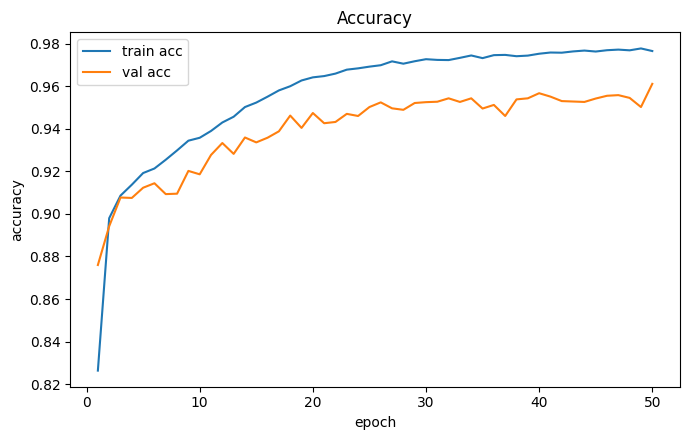

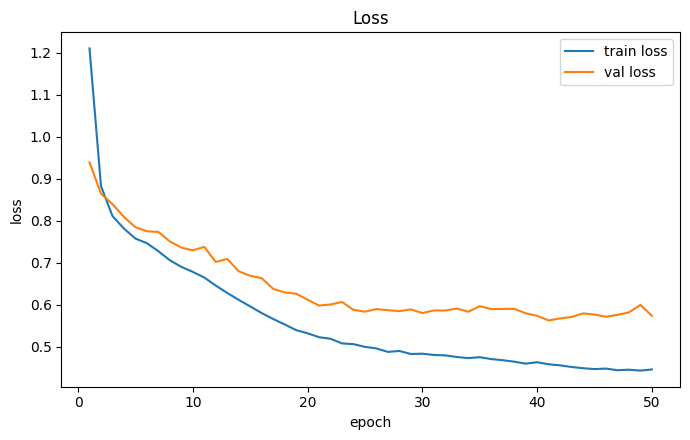

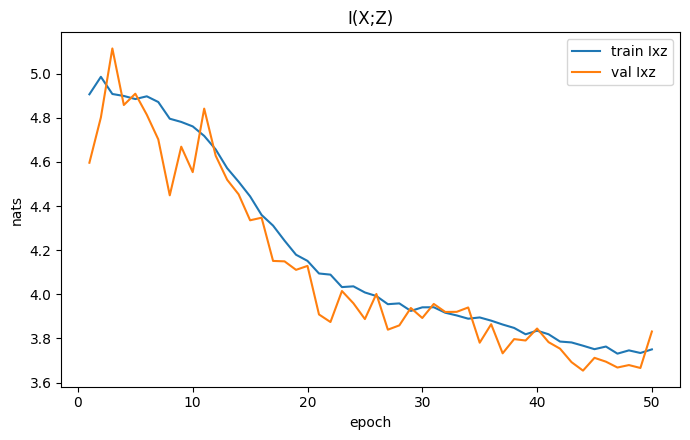

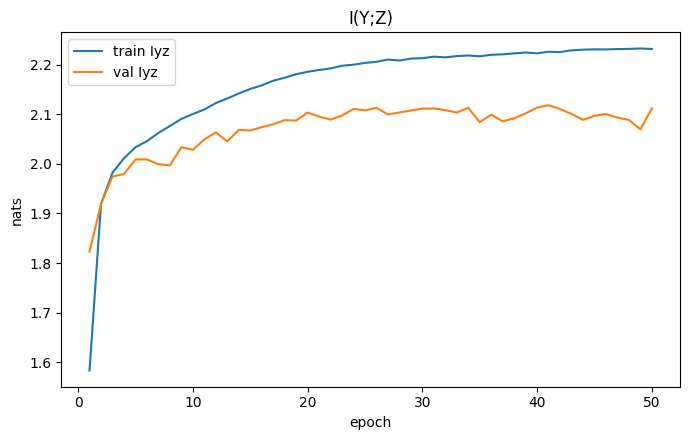

In [8]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_acc, label="train acc")
plt.plot(epochs, val_acc, label="val acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, val_loss, label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_ixz, label="train Ixz")
plt.plot(epochs, val_ixz, label="val Ixz")
plt.xlabel("epoch"); plt.ylabel("nats"); plt.title("I(X;Z)"); plt.legend(); plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(epochs, train_iyz, label="train Iyz")
plt.plot(epochs, val_iyz, label="val Iyz")
plt.xlabel("epoch"); plt.ylabel("nats"); plt.title("I(Y;Z)"); plt.legend(); plt.tight_layout()

plt.show()